## Seminar and homework (10 points total)

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [1]:
!pip3 install tensorflow-gpu>=2.0.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://www.dropbox.com/s/fj9w01embfxvtw1/dummy_checkpoint.npz?dl=1 -O dummy_checkpoint.npz
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2019/week04_seq2seq/utils.py -O utils.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

zsh:1: 2.0.0 not found
zsh:1: no matches found: https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
zsh:1: no matches found: https://www.dropbox.com/s/fj9w01embfxvtw1/dummy_checkpoint.npz?dl=1
zsh:1: command not found: wget


In [1]:
from collections import defaultdict
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('./resource/data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2054.68it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [4]:
from resource.utils import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [5]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
[[   0 2688 2943 1108   29    1    1    1]
 [   0 2922 1834 8035   59 3800   29    1]
 [   0 6030 2083   29    1    1    1    1]
 [   0 4927 1870   29    1    1    1    1]
 [   0 5549 1453   27  592   29    1    1]]

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

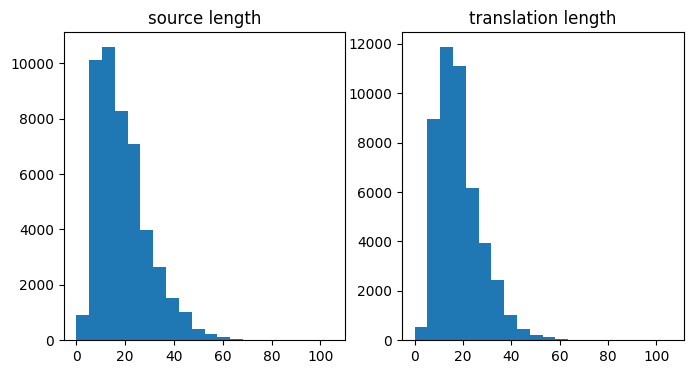

In [6]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [6]:
import tensorflow as tf
assert tf.__version__.startswith('2'), "Current tf version: {}; required: 2.0.*".format(tf.__version__)
L = tf.keras.layers
keras = tf.keras
from resource.utils import infer_length, infer_mask

In [7]:
class BasicModel(L.Layer):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder model
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = L.Embedding(len(inp_voc), emb_size)
        self.emb_out = L.Embedding(len(out_voc), emb_size)
        self.enc0 = L.GRUCell(hid_size)

        self.dec_start = L.Dense(hid_size)
        self.dec0 = L.GRUCell(hid_size)
        self.logits = L.Dense(len(out_voc))

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        # inp_emb = batch*time*emb_size
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        # batch * time
        mask = infer_mask(inp, self.inp_voc.eos_ix, dtype=tf.bool)

        #batch_size * hid_size
        state = [tf.zeros((batch_size, self.hid_size), tf.float32)]

        # mask[:, i, None]: batch*1
        # [1, next_tensor.shape[1]]: 1*hid_size
        # result: batch * hid_size
        # tf.tile(mask[:, i, None], [1, next_tensor.shape[1]])

        # If current sequence is 'valid', change the value of state to next_state
        # Otherwise, keep the value of current state
        for i in tf.range(inp_emb.shape[1]):
            output, next_state = self.enc0(inp_emb[:, i], state)
            state = [
                     tf.where(
                         tf.tile(mask[:, i, None], [1, next_tensor.shape[1]]),
                         next_tensor, tensor
                      ) for tensor, next_tensor in zip(state, next_state)
            ]
        
        dec_start = self.dec_start(state[0])
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors: [batch_size, hid_size]
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        # <YOUR CODE HERE>
        
        # token -> embedding
        out_emb = self.emb_out(prev_tokens)

        # Get output from GRU
        output, new_dec_state = self.dec0(out_emb, prev_state)

        # output-> logit: [batch_size,time,out_voc]
        output_logits = self.logits(output)
        
        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Run decoder on reference tokens (out_tokens) """
        state = initial_state
        batch_size = out_tokens.shape[0]

        # initial logits: always predict BOS
        first_logits = tf.math.log(
            tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix), len(self.out_voc)) + 1e-30)
        outputs = [first_logits]

        for i in tf.range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            outputs.append(logits)

        return tf.stack(outputs, axis=1)

    def call(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        state = initial_state
        outputs = [tf.ones(initial_state[0].shape[0], tf.int32) * self.out_voc.bos_ix]
        all_states = [initial_state]

        for i in tf.range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(tf.argmax(logits, axis=-1, output_type=tf.int32))
            all_states.append(state)
        
        return tf.stack(outputs, axis=1), all_states

    def translate_lines(self, inp_lines):
        inp = tf.convert_to_tensor(inp_voc.to_matrix(inp_lines))

        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state)
        return out_voc.to_lines(out_ids.numpy()), states


In [8]:
model = BasicModel(inp_voc, out_voc)

In [9]:
dummy_inp = tf.convert_to_tensor(inp_voc.to_matrix(train_inp[:3]))
dummy_out = tf.convert_to_tensor(out_voc.to_matrix(train_out[:3]))
dummy_logits = model(dummy_inp, dummy_out)
ref_shape = (dummy_out.shape[0], dummy_out.shape[1], len(out_voc))
assert dummy_logits.shape == ref_shape, "Your logits shape should be {} but got {}".format(dummy_logits.shape, ref_shape)
assert all(dummy_logits[:, 0].numpy().argmax(-1) == out_voc.bos_ix), "first step must always be BOS"

In [10]:
dummy_inp.shape, dummy_out.shape, dummy_logits.shape

(TensorShape([3, 25]), TensorShape([3, 24]), TensorShape([3, 24, 7801]))

### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [11]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use infer_length or infer_mask)
    """
    inp, out = map(tf.convert_to_tensor, [inp, out])
    targets_1hot = tf.one_hot(out, len(model.out_voc), dtype=tf.float32)
    mask = infer_mask(out, out_voc.eos_ix) # [batch_size, out_len]

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = tf.math.log(tf.nn.softmax(logits_seq))
   
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = -tf.reduce_sum(logprobs_seq * targets_1hot, axis=-1)

    # mean cross-entropy over tokens where mask == 1
    return tf.reduce_sum(logp_out*mask) / tf.reduce_sum(mask) # scalar

In [12]:
dummy_loss = compute_loss(model, dummy_inp, dummy_out)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss, 8.425, rtol=0.1, atol=0.1), "We're sorry for your loss"

Loss: tf.Tensor(8.424328, shape=(), dtype=float32)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [13]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    translations = model.translate_lines(inp_lines, **flags)[0]
    translations = [line.replace(bpe_sep, '') for line in translations] 
    return corpus_bleu(
        [[ref.split()] for ref in out_lines],
        [trans.split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [262]:
compute_bleu(model, dev_inp, dev_out)

0.0020462937728193257

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [14]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

# opt = keras.optimizers.Adam(1e-3)
opt = tf.keras.optimizers.legacy.Adam(1e-3)
batch_size = 32

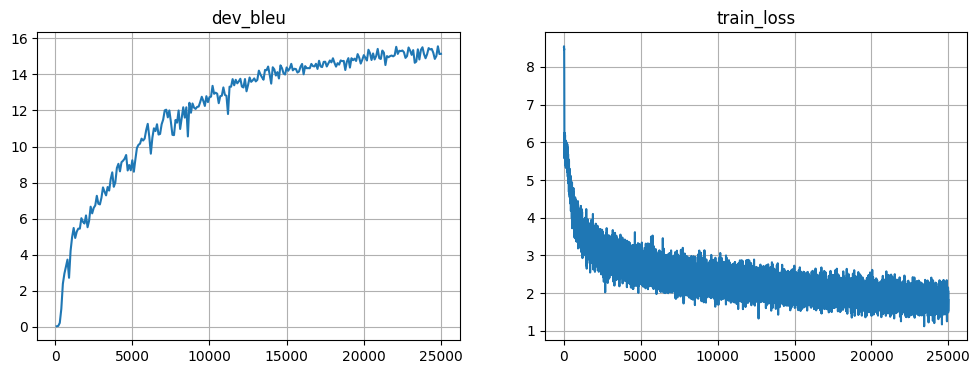

Mean loss=1.805


100%|██████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [2:23:42<00:00,  2.90it/s]


In [264]:
for _ in trange(25000):
# for _ in trange(100):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(model, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    
    metrics['train_loss'].append((step, loss_t.numpy()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [266]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [278]:
for inp_line, label_line, trans_line in zip(dev_inp[::500], dev_out[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(label_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
a shared equipped kitchen and a common living room are provided to guests .
guests can use a shared kitchen with a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental and shuttle services are also available . the property offers free parking .
bike hire is available at the property and the area is popular for skiing .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the unit is 26 km from kissimmee .
the unit is 55 km from the accommodation is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
situated 5 minutes ' walk from the beach in cabo ro@@ ig , this air - conditioned penthouse apartment features a communal outdoor pool , garden and sun terrace .
located in a quiet area of marina , apartment mara offers a g

# Homework code templates will appear here soon!

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (3 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [15]:
class AttentionLayer(L.Layer):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=tf.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self._name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

    def build(self, input_shape):
        # create layer variables
        self.w_enc = tf.Variable(tf.random.normal([self.enc_size, self.hid_size],stddev=0.1), name='w_enc')
        # self.b_enc = tf.Variable(tf.zeros([self.hid_size]), name='b_enc')
        self.w_dec = tf.Variable(tf.random.normal([self.dec_size, self.hid_size],stddev=0.1), name='w_dec')
        # self.b_dec = tf.Variable(tf.zeros([self.hid_size]), name='b_dec')
        self.w_out = tf.Variable(tf.random.normal([self.hid_size, 1],stddev=0.1), name='w_out')
        # self.b_out = tf.Variable(tf.zeros([1]), name='b_out')
        
        # Hint: you can find an example of custom layer here:
        # https://www.tensorflow.org/tutorials/customization/custom_layers

    def call(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits
        # logits = self.activ(tf.matmul(enc,self.w_enc) + self.b_enc + tf.matmul(dec,self.w_dec) + self.b_dec)

        
        linear_enc = tf.matmul(enc,self.w_enc) # [batch,ninp,hidden_size]
        linear_dec = tf.reshape(tf.matmul(dec,self.w_dec),[dec.shape[0], 1, self.hid_size]) # [batch,1,hidden_size]
        
        # [batch,ninp]
        logits = tf.reshape(tf.matmul(self.activ(linear_enc+linear_dec), self.w_out),[enc.shape[0],enc.shape[1]])

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need tf.where
        # print(inp_mask.shape, logits.shape)
        logits_valid = tf.where(inp_mask,logits,[-1e9])

        # Compute attention probabilities (softmax)
        probs = tf.nn.softmax(logits_valid)

        # Compute attention response using enc and probs
        attn = tf.reduce_sum(enc*(tf.reshape(probs,list(probs.shape) + [-1])),axis=1)

        return attn, probs

### Seq2seq model with attention (3 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [20]:
# Get the idea from 
# https://github.com/denzel-lito/yandexdataschool_nlp_course/blob/main/week04_seq2seq/practice_and_homework_pytorch.ipynb
class CopyAttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
    # def __init__(self, name, inp_voc, out_voc, enc_size, dec_size,
    #              emb_size=64, hid_size=128, attn_size=128):
        
        """ Translation model that uses attention. See instructions above. """
        L.Layer.__init__(self) # initialize base class to track sub-layers, trainable variables, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        # <YOUR CODE: initialize layers>
        self.attn_size = attn_size
        # self.enc_size, self.dec_size = enc_size, dec_size

        self.emb_inp = L.Embedding(len(inp_voc), emb_size, name='emb_inp')
        self.emb_out = L.Embedding(len(out_voc), emb_size, name='emb_out')
        self.enc0 = L.GRUCell(hid_size, name='enc_gru')

        self.dec_start = L.Dense(hid_size, name='dec_start')
        # self.dec_process = L.Dense(dec_size, name='dec_process')
        self.dec0 = L.GRUCell(hid_size, name='dec_gru')
        self.logits = L.Dense(len(out_voc))

        self.attention = AttentionLayer('att', hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        # <YOUR CODE>
        
        # inp_emb = batch*time*emb_size
        inp_emb = self.emb_inp(inp)

        inp_mask = infer_mask(inp, self.inp_voc.eos_ix, dtype=tf.bool)

        initial_state = tf.zeros((inp_emb.shape[0], self.hid_size), tf.float32)
        state = [initial_state]
        encoder_state = []
        
        for i in tf.range(inp_emb.shape[1]):
            output, next_state = self.enc0(inp_emb[:, i], state)

            state = [
                     tf.where(
                         tf.tile(inp_mask[:, i, None], [1, next_tensor.shape[1]]),
                         next_tensor, tensor
                      ) for tensor, next_tensor in zip(state, next_state)
            ]
            encoder_state.append(state[0])

        encoder_state = tf.stack(encoder_state,axis=1)

        last_state = encoder_state[:,-1,:]
        dec_start = self.dec_start(last_state)

        _, first_attn_probas = self.attention(encoder_state, dec_start, inp_mask) 

        first_state = dec_start, encoder_state, inp_mask, first_attn_probas

        return first_state

    def decode(self, initial_state, out_tokens, **flags):
        """ Run decoder on reference tokens (out_tokens) """
        state = initial_state
        batch_size = out_tokens.shape[0]

        # initial logits: always predict BOS
        first_logits = tf.math.log(
            tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix), len(self.out_voc)) + 1e-30)
        outputs = [first_logits]

        for i in tf.range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            outputs.append(logits)

        return tf.stack(outputs, axis=1)

    def decode_step(self, prev_state, prev_tokens, **flags):

        prev_gru0_state, enc_seq, inp_mask, _ = prev_state
        # print('prev_gru0_state shape:', prev_gru0_state.shape)
        # print('enc_seq shape:', enc_seq.shape)
        
        emb_prev_tokens = self.emb_out(prev_tokens)
        # print('emb_prev_tokens shape:', emb_prev_tokens.shape)
        output, new_state = self.dec0(emb_prev_tokens, prev_gru0_state)
        # print(new_state.shape)
        
        attn, attn_prob = self.attention(enc_seq, new_state, inp_mask)    

        cat = tf.concat([new_state, attn], -1)
        # cat = torch.cat([new_state, attn], dim=-1)                    
        output_logits = self.logits(cat)
        
        new_dec_state = [new_state, enc_seq, inp_mask, attn_prob]
        return new_dec_state, output_logits

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        state = initial_state
        outputs = [tf.ones(initial_state[0].shape[0], tf.int32) * self.out_voc.bos_ix]
        all_states = [initial_state]

        for i in tf.range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(tf.argmax(logits, axis=-1, output_type=tf.int32))
            all_states.append(state)
        
        return tf.stack(outputs, axis=1), all_states

    def translate_lines(self, inp_lines):
        inp = tf.convert_to_tensor(inp_voc.to_matrix(inp_lines))

        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state)
        return out_voc.to_lines(out_ids.numpy()), states
        


In [29]:
class AttentiveModel(BasicModel):
    # def __init__(self, name, inp_voc, out_voc,
    #              emb_size=64, hid_size=128, attn_size=128):
    def __init__(self, name, inp_voc, out_voc, enc_size, dec_size,
                 emb_size=64, hid_size=128, attn_size=128):
        
        """ Translation model that uses attention. See instructions above. """
        L.Layer.__init__(self) # initialize base class to track sub-layers, trainable variables, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        # <YOUR CODE: initialize layers>
        self.attn_size = attn_size
        self.enc_size, self.dec_size = enc_size, dec_size

        self.emb_inp = L.Embedding(len(inp_voc), emb_size, name='emb_inp')
        self.emb_out = L.Embedding(len(out_voc), emb_size, name='emb_out')
        self.enc0 = L.GRUCell(enc_size, name='enc_gru')

        self.dec_start = L.Dense(dec_size, name='dec_start')
        self.dec_process = L.Dense(dec_size, name='dec_process')
        self.dec0 = L.GRUCell(dec_size, name='dec_gru')
        self.logits = L.Dense(len(out_voc))

        self.attention = AttentionLayer('att', self.enc_size, self.dec_size, attn_size, activ=tf.tanh)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        # <YOUR CODE>
        
        # inp_emb = batch*time*emb_size
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        # print('inp_emb shape:', inp_emb.shape)

        # batch * time
        mask = infer_mask(inp, self.inp_voc.eos_ix, dtype=tf.bool)
        # print('mask shape:', mask.shape)

        #batch_size * enc_size
        state = [tf.zeros((batch_size, self.enc_size), tf.float32)]
        # state = tf.zeros((batch_size, self.enc_size), tf.float32)

        # batch_size*time*encoder_size
        encoder_state = []

        # Run RNN(encoder) to get encode_states
        for i in tf.range(inp_emb.shape[1]):
            output, next_state = self.enc0(inp_emb[:, i], state)

            state = [
                     tf.where(
                         tf.tile(mask[:, i, None], [1, next_tensor.shape[1]]),
                         next_tensor, tensor
                      ) for tensor, next_tensor in zip(state, next_state)
            ]
            # print('state shape:', state[0].shape)
            encoder_state.append(state[0])

        return tf.stack(encoder_state,axis=1), mask

        # initial_decoder = encoder_state[-1]
        
        # apply attention layer from initial decoder hidden state
        # first_attn_probas = <...>
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        # first_state = [<...>, first_attn_probas]
        # return first_state

    def decode(self, encoder_state, out_tokens, inp_mask, **flags):

        # print('encoder_state shape:', encoder_state.shape)

        # batch*time*emb_size
        out_emb = self.emb_out(out_tokens)
        batch_size = out_tokens.shape[0]
        # print('out_emb shape:', out_emb.shape)
        
        # initial logits: always predict BOS
        first_logits = tf.math.log(
            tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix), len(self.out_voc)) + 1e-30)
        outputs = [first_logits]


        # initial state is the last encoder state
        initial_state = encoder_state[:,-1,:]
        # change it size from encoder_size to decoder_size
        state = tf.keras.activations.relu(self.dec_start(initial_state))


        # for i in tf.range(out_tokens.shape[1] - 1):
        #     output_logits, state = self.decode_step(out_emb[:, i], state, encoder_state, inp_mask)
        #     outputs.append(logits)

        for i in tf.range(out_tokens.shape[1] - 1):
            # output: [batch,dec_size], state: [batch,dec_size]
            output, state = self.dec0(out_emb[:, i], state) #out_emb[:, i].shape = [batch, emb_size]

            # convert decoder output to output probability
            output_logits = self.logits(output)
            outputs.append(output_logits)

            # encoder_state: [batch, ninp, enc_size] state: [batch, dec_size], inp_mask: [batch_size, ninp]
            # attn[batch_size, enc_size], probs[batch_size, ninp]
            attn, probs = self.attention(encoder_state, state, inp_mask)

            # process and get the state for next
            cat = tf.concat([state, tf.keras.activations.relu(self.dec_start(attn))], -1)
            state = tf.keras.activations.relu(self.dec_process(cat))            
            # state = tf.keras.activations.relu(
            #     self.dec_process(
            #         tf.keras.activations.relu(self.dec_start(attn)) + state
            #     )
            # )
        return tf.stack(outputs, axis=1)
        
   
    def decode_step(self, prev_tokens, prev_state, encoder_state, inp_mask, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        output, state = self.dec0(prev_tokens, prev_state)
        
        # convert decoder output to output probability
        output_logits = self.logits(output)
        
        # encoder_state: [batch, ninp, enc_size] state: [batch, dec_size], inp_mask: [batch_size, ninp]
        # attn[batch_size, enc_size], probs[batch_size, ninp]
        attn, probs = self.attention(encoder_state, state, inp_mask)

        # process and get the state for next
        cat = tf.concat([state, tf.keras.activations.relu(self.dec_start(attn))], -1)
        new_dec_state = tf.keras.activations.relu(self.dec_process(cat))  
        
        # new_dec_state = tf.keras.activations.relu(
        #     self.dec_process(
        #         tf.keras.activations.relu(self.dec_start(attn)) + state
        #     )
        # ) 
        return output_logits, new_dec_state, probs
        
    def call(self, inp, out):
        """ Apply model in training mode """
        encoder_state, inp_mask = self.encode(inp)
        return self.decode(encoder_state, out, inp_mask)

    def decode_inference(self, encoder_state, inp_mask, max_len=100, **flags):
        """ Generate translations from model (greedy version) """

        # print('encoder_state shape:', encoder_state.shape)

        batch_size = encoder_state.shape[0]

        # initial logits: always predict BOS

        # outputs_1 = [tf.ones(batch_size, tf.int32) * self.out_voc.bos_ix]
        
        first_logits = tf.math.log(
            tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix), len(self.out_voc)) + 1e-30)
        # print(first_logits.shape)
        # [batch, voc]
        outputs = [tf.argmax(first_logits, axis=-1, output_type=tf.int32)]

        # return outputs_1, outputs
        # print('outputs shape:', outputs[-1].shape, self.emb_out(outputs[-1]).shape)

        # initial state is the last encoder state
        initial_state = encoder_state[:,-1,:]
        # change it size from encoder_size to decoder_size
        state = tf.keras.activations.relu(self.dec_start(initial_state))
        # print('state shape:', state.shape)

        states = [state]
        attention_probs = [tf.zeros([batch_size, encoder_state.shape[1]],dtype=tf.float32)]

        for i in tf.range(max_len):
            # print(outputs[-1].shape, self.emb_out(outputs[-1]).shape, encoder_state.shape, initial_state.shape, state.shape)
            output_logits, state, probs = self.decode_step(self.emb_out(outputs[-1]), state, encoder_state, inp_mask)
            outputs.append(tf.argmax(output_logits, axis=-1, output_type=tf.int32))
            states.append(state)
            attention_probs.append(probs)
            # outputs.append(logits)

        return tf.stack(outputs, axis=1), states, tf.stack(attention_probs, axis=1)

        # ###
        # state = encoder_state
        # outputs = [tf.ones(initial_state[0].shape[0], tf.int32) * self.out_voc.bos_ix]
        # all_states = [initial_state]

        # for i in tf.range(max_len):
        #     state, logits = self.decode_step(state, outputs[-1])
        #     outputs.append(tf.argmax(logits, axis=-1, output_type=tf.int32))
        #     all_states.append(state)
        
        # return tf.stack(outputs, axis=1), all_states

    def translate_lines(self, inp_lines):
        inp = tf.convert_to_tensor(inp_voc.to_matrix(inp_lines))
        # print('input shape',inp.shape)
        encoder_state, inp_mask = self.encode(inp)
        
        out_ids, states, probs = self.decode_inference(encoder_state, inp_mask)
        # return out_ids, states
        
        return self.out_voc.to_lines(out_ids.numpy()), states, probs
    


In [718]:
# Legacy one
class AttentiveModel(BasicModel):
    # def __init__(self, name, inp_voc, out_voc,
    #              emb_size=64, hid_size=128, attn_size=128):
    def __init__(self, name, inp_voc, out_voc, enc_size, dec_size,
                 emb_size=64, hid_size=128, attn_size=128):
        
        """ Translation model that uses attention. See instructions above. """
        L.Layer.__init__(self) # initialize base class to track sub-layers, trainable variables, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        # <YOUR CODE: initialize layers>
        self.attn_size = attn_size
        self.enc_size, self.dec_size = enc_size, dec_size

        self.emb_inp = L.Embedding(len(inp_voc), emb_size, name='emb_inp')
        self.emb_out = L.Embedding(len(out_voc), emb_size, name='emb_out')
        self.enc0 = L.GRUCell(enc_size, name='enc_gru')

        self.dec_start = L.Dense(dec_size, name='dec_start')
        self.dec_process = L.Dense(dec_size, name='dec_process')
        self.dec0 = L.GRUCell(dec_size, name='dec_gru')
        self.logits = L.Dense(len(out_voc))

        self.attention = AttentionLayer('att', self.enc_size, self.dec_size, attn_size, activ=tf.tanh)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        # <YOUR CODE>
        
        # inp_emb = batch*time*emb_size
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        # print('inp_emb shape:', inp_emb.shape)

        # batch * time
        mask = infer_mask(inp, self.inp_voc.eos_ix, dtype=tf.bool)
        # print('mask shape:', mask.shape)

        #batch_size * enc_size
        state = [tf.zeros((batch_size, self.enc_size), tf.float32)]
        # state = tf.zeros((batch_size, self.enc_size), tf.float32)

        # batch_size*time*encoder_size
        encoder_state = []

        # Run RNN(encoder) to get encode_states
        for i in tf.range(inp_emb.shape[1]):
            output, next_state = self.enc0(inp_emb[:, i], state)

            state = [
                     tf.where(
                         tf.tile(mask[:, i, None], [1, next_tensor.shape[1]]),
                         next_tensor, tensor
                      ) for tensor, next_tensor in zip(state, next_state)
            ]
            # print('state shape:', state[0].shape)
            encoder_state.append(state[0])

        return tf.stack(encoder_state,axis=1), mask

        # initial_decoder = encoder_state[-1]
        
        # apply attention layer from initial decoder hidden state
        # first_attn_probas = <...>
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        # first_state = [<...>, first_attn_probas]
        # return first_state

    def decode(self, encoder_state, out_tokens, inp_mask, **flags):

        # print('encoder_state shape:', encoder_state.shape)

        # batch*time*emb_size
        out_emb = self.emb_out(out_tokens)
        batch_size = out_tokens.shape[0]
        # print('out_emb shape:', out_emb.shape)
        
        # initial logits: always predict BOS
        first_logits = tf.math.log(
            tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix), len(self.out_voc)) + 1e-30)
        outputs = [first_logits]


        # initial state is the last encoder state
        initial_state = encoder_state[:,-1,:]
        # change it size from encoder_size to decoder_size
        state = tf.keras.activations.relu(self.dec_start(initial_state))


        # for i in tf.range(out_tokens.shape[1] - 1):
        #     output_logits, state = self.decode_step(out_emb[:, i], state, encoder_state, inp_mask)
        #     outputs.append(logits)

        for i in tf.range(out_tokens.shape[1] - 1):
            # output: [batch,dec_size], state: [batch,dec_size]
            output, state = self.dec0(out_emb[:, i], state) #out_emb[:, i].shape = [batch, emb_size]

            # convert decoder output to output probability
            output_logits = self.logits(output)
            outputs.append(output_logits)

            # encoder_state: [batch, ninp, enc_size] state: [batch, dec_size], inp_mask: [batch_size, ninp]
            # attn[batch_size, enc_size], probs[batch_size, ninp]
            attn, probs = self.attention(encoder_state, state, inp_mask)

            # process and get the state for next
            state = tf.keras.activations.relu(
                self.dec_process(
                    tf.keras.activations.relu(self.dec_start(attn)) + state
                )
            )
        return tf.stack(outputs, axis=1)
        
   
    def decode_step(self, prev_tokens, prev_state, encoder_state, inp_mask, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        output, state = self.dec0(prev_tokens, prev_state)
        
        # convert decoder output to output probability
        output_logits = self.logits(output)
        
        # encoder_state: [batch, ninp, enc_size] state: [batch, dec_size], inp_mask: [batch_size, ninp]
        # attn[batch_size, enc_size], probs[batch_size, ninp]
        attn, probs = self.attention(encoder_state, state, inp_mask)

        # process and get the state for next
        new_dec_state = tf.keras.activations.relu(
            self.dec_process(
                tf.keras.activations.relu(self.dec_start(attn)) + state
            )
        ) 
        return output_logits, new_dec_state, probs
        
    def call(self, inp, out):
        """ Apply model in training mode """
        encoder_state, inp_mask = self.encode(inp)
        return self.decode(encoder_state, out, inp_mask)

    def decode_inference(self, encoder_state, inp_mask, max_len=100, **flags):
        """ Generate translations from model (greedy version) """

        # print('encoder_state shape:', encoder_state.shape)

        batch_size = encoder_state.shape[0]

        # initial logits: always predict BOS

        # outputs_1 = [tf.ones(batch_size, tf.int32) * self.out_voc.bos_ix]
        
        first_logits = tf.math.log(
            tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix), len(self.out_voc)) + 1e-30)
        # print(first_logits.shape)
        # [batch, voc]
        outputs = [tf.argmax(first_logits, axis=-1, output_type=tf.int32)]

        # return outputs_1, outputs
        # print('outputs shape:', outputs[-1].shape, self.emb_out(outputs[-1]).shape)

        # initial state is the last encoder state
        initial_state = encoder_state[:,-1,:]
        # change it size from encoder_size to decoder_size
        state = tf.keras.activations.relu(self.dec_start(initial_state))
        # print('state shape:', state.shape)

        states = [state]
        attention_probs = [tf.zeros([batch_size, encoder_state.shape[1]],dtype=tf.float32)]

        for i in tf.range(max_len):
            # print(outputs[-1].shape, self.emb_out(outputs[-1]).shape, encoder_state.shape, initial_state.shape, state.shape)
            output_logits, state, probs = self.decode_step(self.emb_out(outputs[-1]), state, encoder_state, inp_mask)
            outputs.append(tf.argmax(output_logits, axis=-1, output_type=tf.int32))
            states.append(state)
            attention_probs.append(probs)
            # outputs.append(logits)

        return tf.stack(outputs, axis=1), states, tf.stack(attention_probs, axis=1)

        # ###
        # state = encoder_state
        # outputs = [tf.ones(initial_state[0].shape[0], tf.int32) * self.out_voc.bos_ix]
        # all_states = [initial_state]

        # for i in tf.range(max_len):
        #     state, logits = self.decode_step(state, outputs[-1])
        #     outputs.append(tf.argmax(logits, axis=-1, output_type=tf.int32))
        #     all_states.append(state)
        
        # return tf.stack(outputs, axis=1), all_states

    def translate_lines(self, inp_lines):
        inp = tf.convert_to_tensor(inp_voc.to_matrix(inp_lines))
        # print('input shape',inp.shape)
        encoder_state, inp_mask = self.encode(inp)
        
        out_ids, states, probs = self.decode_inference(encoder_state, inp_mask)
        # return out_ids, states
        
        return self.out_voc.to_lines(out_ids.numpy()), states, probs
    


### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [33]:
# <YOUR CODE: create AttentiveModel and training utilities>

attmodel = AttentiveModel('attention', inp_voc, out_voc, enc_size=32, dec_size=28)

metricsatt = {'train_loss': [], 'dev_bleu': [] }
grad_att_mean = defaultdict(list)
grad_att_std = defaultdict(list)

# opt = keras.optimizers.Adam(1e-3)
# opt2 = tf.keras.optimizers.legacy.Adam(1e-3)
opt_att = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)
batch_size = 32

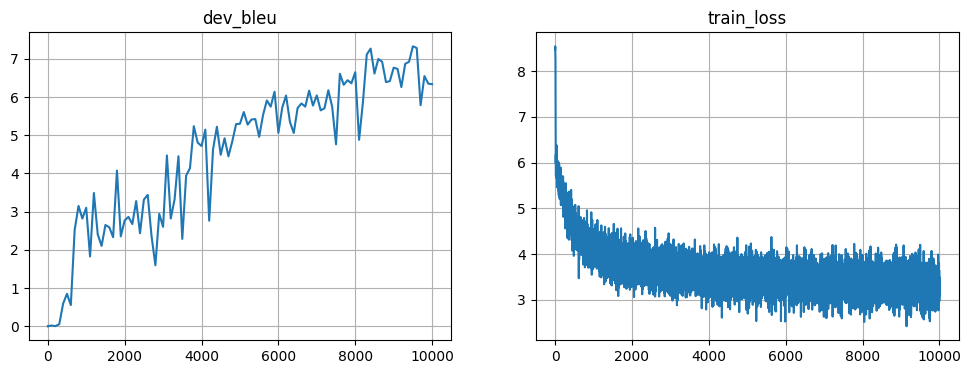

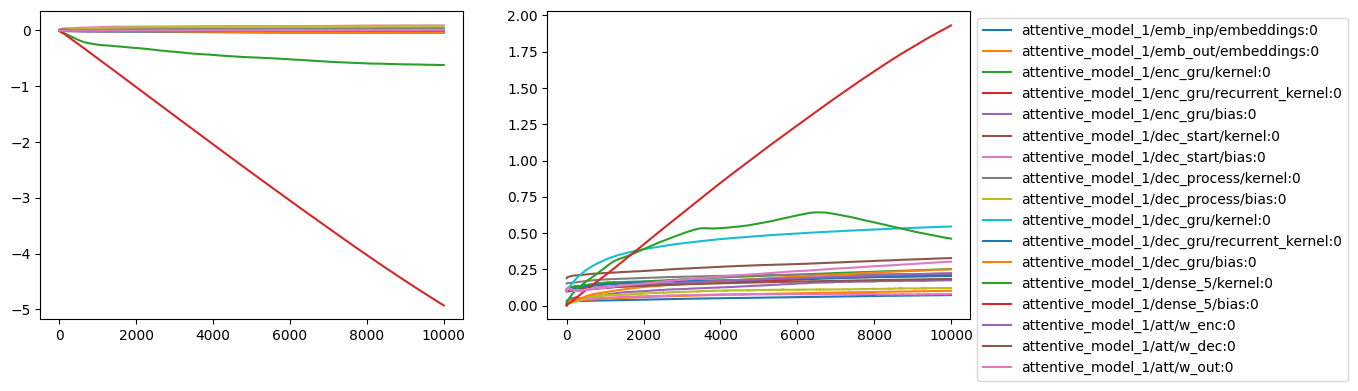

Mean loss=3.377


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [24:58<00:00,  2.00it/s]


In [95]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(3000):
    step = len(metricsatt['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(attmodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, attmodel.trainable_variables)
    opt2.apply_gradients(zip(grads, attmodel.trainable_variables))
    
    metricsatt['train_loss'].append((step, loss_t.numpy()))

    for v in attmodel.variables:
        grad_att_mean[v.name].append(np.mean(v.numpy()))
        grad_att_std[v.name].append(np.std(v.numpy()))
    
    if step % 100 == 0:
        metricsatt['dev_bleu'].append((step, compute_bleu(attmodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metricsatt.items())):
            plt.subplot(1, len(metricsatt), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        x = range(1,step+1)
        plt.subplot(1,2,1)
        for key in grad_att_mean:
            plt.plot(x,grad_att_mean[key],label = key)
            # plt.legend(loc=2,bbox_to_anchor=(1, 1))

        plt.subplot(1,2,2)
        for key in grad_att_std:
            plt.plot(x,grad_att_std[key],label = key)
        plt.legend(loc=2,bbox_to_anchor=(1, 1))     
        plt.show()
            
        
        print("Mean loss=%.3f" % np.mean(metricsatt['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [130]:
# <YOUR CODE: measure final BLEU>

assert np.mean(metricsatt['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

AssertionError: We kind of need a higher bleu BLEU from you. Kind of right now.

### Training copy attentive model

In [119]:
import pickle

def save_weight(model, weight_path):
    """Save model weights locally"""

    weights = model.get_weights()
    with open(weight_path, 'wb') as f:
        pickle.dump(weights, f)

def load_weight(model, weight_path):
    """Initialize and load model weights locally"""

    dummy_inp = tf.convert_to_tensor(inp_voc.to_matrix(train_inp[:3]))
    dummy_out = tf.convert_to_tensor(out_voc.to_matrix(train_out[:3]))
    dummy_logits = model(dummy_inp, dummy_inp)

    with open(weight_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

In [125]:
save_weight(attmodel, weight_path='./attmodel_weights.pkl')

In [126]:
attmodel2 = AttentiveModel('attention', inp_voc, out_voc, enc_size=32, dec_size=28)
load_weight(attmodel2, weight_path='./attmodel_weights.pkl')

In [127]:
save_weight(copymodel, weight_path='./copymodel_wei.pkl')

In [121]:
copymodel3 = CopyAttentiveModel('attention', inp_voc, out_voc)
load_weight(copymodel3, weight_path='./testcopy.pkl')

In [23]:
# <YOUR CODE: create AttentiveModel and training utilities>

copymodel = CopyAttentiveModel('attention', inp_voc, out_voc)

metricscopy = {'train_loss': [], 'dev_bleu': [] }
grad_copy_mean = defaultdict(list)
grad_copy_std = defaultdict(list)

# # opt = keras.optimizers.Adam(1e-3)
# # opt2 = tf.keras.optimizers.legacy.Adam(1e-3)
opt2 = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)
batch_size = 32

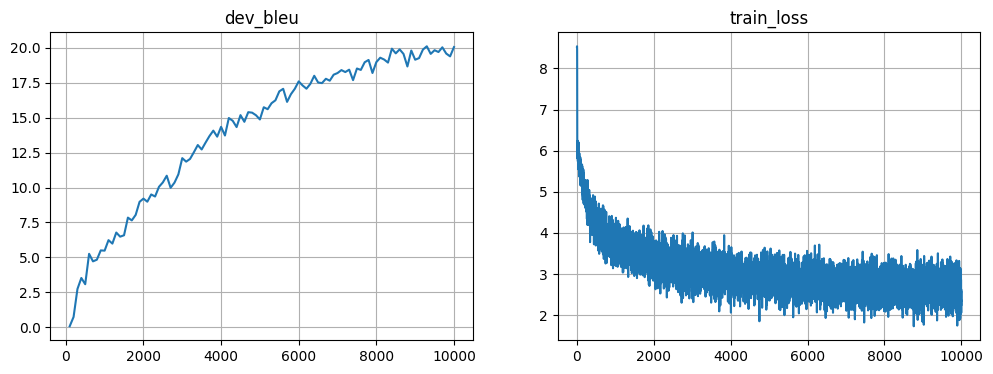

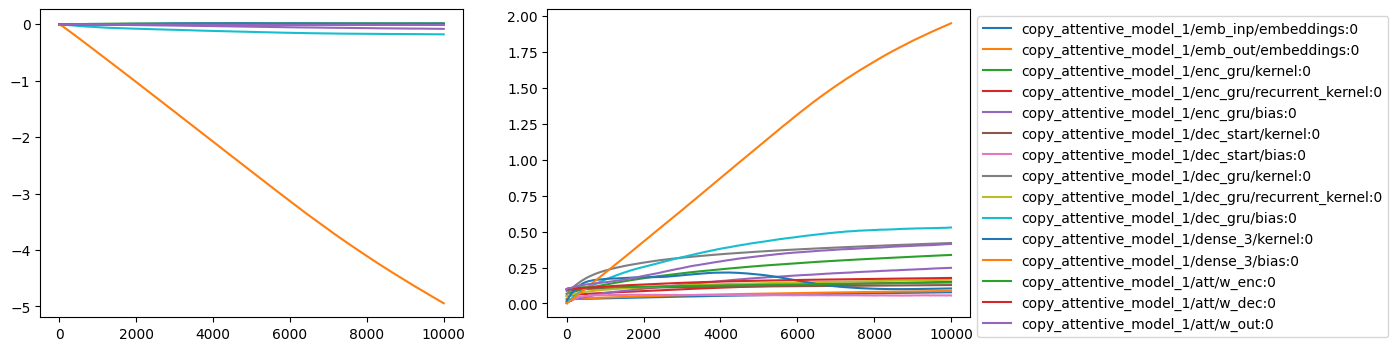

Mean loss=2.493


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:30:03<00:00,  2.52s/it]


In [91]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(5000):
    step = len(metricscopy['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(copymodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, copymodel.trainable_variables)
    opt2.apply_gradients(zip(grads, copymodel.trainable_variables))
    
    metricscopy['train_loss'].append((step, loss_t.numpy()))

    for v in copymodel.variables:
        grad_copy_mean[v.name].append(np.mean(v.numpy()))
        grad_copy_std[v.name].append(np.std(v.numpy()))
    
    if step % 100 == 0:
        metricscopy['dev_bleu'].append((step, compute_bleu(copymodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metricscopy.items())):
            plt.subplot(1, len(metricscopy), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        x = range(1,step+1)
        plt.subplot(1,2,1)
        for key in grad_copy_mean:
            plt.plot(x,grad_copy_mean[key],label = key)
            # plt.legend(loc=2,bbox_to_anchor=(1, 1))

        plt.subplot(1,2,2)
        for key in grad_copy_std:
            plt.plot(x,grad_copy_std[key],label = key)
        plt.legend(loc=2,bbox_to_anchor=(1, 1))     
        plt.show()
            
        
        print("Mean loss=%.3f" % np.mean(metricscopy['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [129]:
# <YOUR CODE: measure final BLEU>

assert np.mean(metricscopy['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

### Deprecated/legacy training code

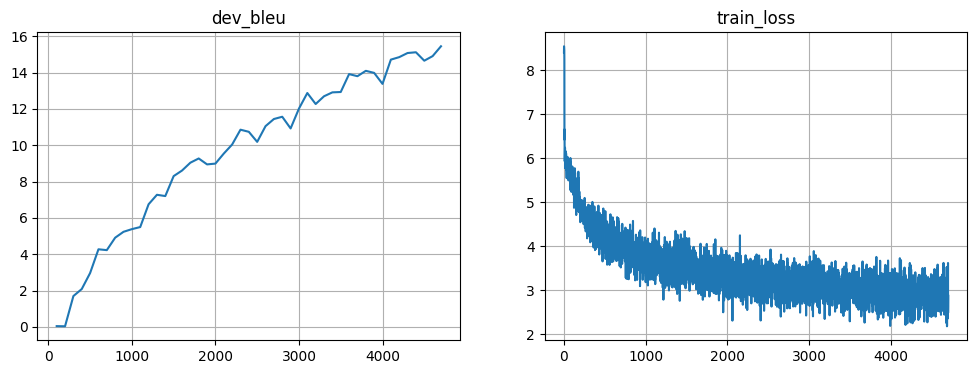

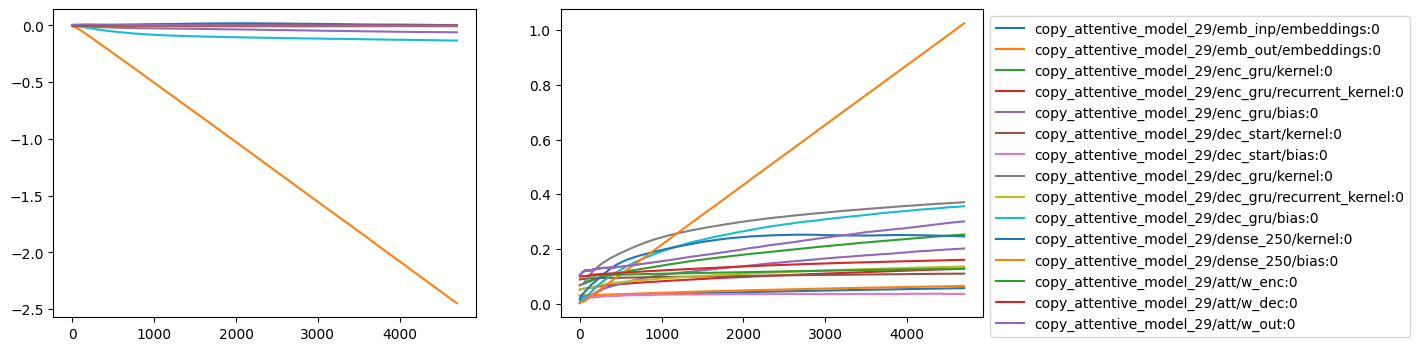

Mean loss=2.905


 56%|████████████████████████████████████████████████████▌                                         | 2798/5000 [40:25<24:57,  1.47it/s]

In [ ]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(5000):
    step = len(metricscopy['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(copymodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, copymodel.trainable_variables)
    opt2.apply_gradients(zip(grads, copymodel.trainable_variables))
    
    metricscopy['train_loss'].append((step, loss_t.numpy()))

    for v in copymodel.variables:
        grad_copy_mean[v.name].append(np.mean(v.numpy()))
        grad_copy_std[v.name].append(np.std(v.numpy()))
    
    if step % 100 == 0:
        metricscopy['dev_bleu'].append((step, compute_bleu(copymodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metricscopy.items())):
            plt.subplot(1, len(metricscopy), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        x = range(1,step+1)
        plt.subplot(1,2,1)
        for key in grad_copy_mean:
            plt.plot(x,grad_copy_mean[key],label = key)
            # plt.legend(loc=2,bbox_to_anchor=(1, 1))

        plt.subplot(1,2,2)
        for key in grad_copy_std:
            plt.plot(x,grad_copy_std[key],label = key)
        plt.legend(loc=2,bbox_to_anchor=(1, 1))     
        plt.show()
            
        
        print("Mean loss=%.3f" % np.mean(metricscopy['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [28]:
interval = 100
for inp_line, label_line, trans_line in zip(dev_inp[::interval], dev_out[::interval], copymodel.translate_lines(dev_inp[::interval])[0]):
    print(inp_line)
    print(label_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
a shared equipped kitchen and a common living room are provided to guests .
a shared kitchen is available .

гости могут посещать сезонный открытый бассейн .
other facilities at pearl one include a seasonal outdoor pool .
guests can enjoy the on - site restaurant .

wifi и парковка предоставляются бесплатно .
wi - fi and parking are free .
free wifi is available and free private parking is available on site .

в окрестностях можно заняться различными видами дея@@ тель@@ ности , включая пешие прогулки , велоспорт и походы .
several activities can be enjoyed in the area , such as hiking , cycling and walking .
an array of activities can be enjoyed on site or in the surroundings , including cycling and hiking .

в номерах имеется телевизор с плоским экраном и собственная ванная комната .
the guest rooms feature a flat - screen tv and private bathroom .
each room is equipped with a flat - screen tv .

кроме того , предоставляется прокат 

In [464]:
dummy_inp = tf.convert_to_tensor(inp_voc.to_matrix(train_inp[:3]))
dummy_out = tf.convert_to_tensor(out_voc.to_matrix(train_out[:3]))
dummy_logits = amodel(dummy_inp, dummy_inp)
dummy_loss = compute_loss(amodel, dummy_inp, dummy_out)

In [622]:
aaamodel = AttentiveModel('attention', inp_voc, out_voc, enc_size=32, dec_size=28)

In [491]:
# <YOUR CODE: create AttentiveModel and training utilities>

amodel = AttentiveModel('attention', inp_voc, out_voc, enc_size=32, dec_size=28)

metrics2 = {'train_loss': [], 'dev_bleu': [] }

# opt = keras.optimizers.Adam(1e-3)
# opt2 = tf.keras.optimizers.legacy.Adam(1e-3)
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)
batch_size = 32

In [683]:
# <YOUR CODE: create AttentiveModel and training utilities>

amodel = AttentiveModel('attention', inp_voc, out_voc, enc_size=32, dec_size=28)

metrics2 = {'train_loss': [], 'dev_bleu': [] }

grad_mean = defaultdict(list)
grad_std = defaultdict(list)

# opt = keras.optimizers.Adam(1e-3)
# opt2 = tf.keras.optimizers.legacy.Adam(1e-3)
opt2 = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)
batch_size = 32

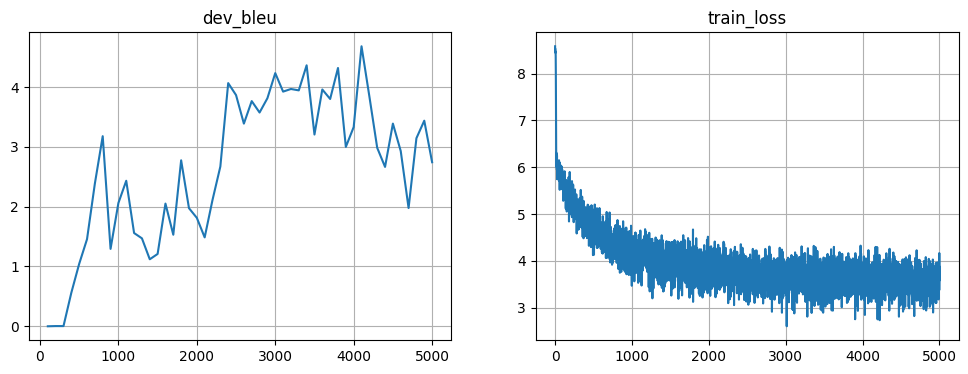

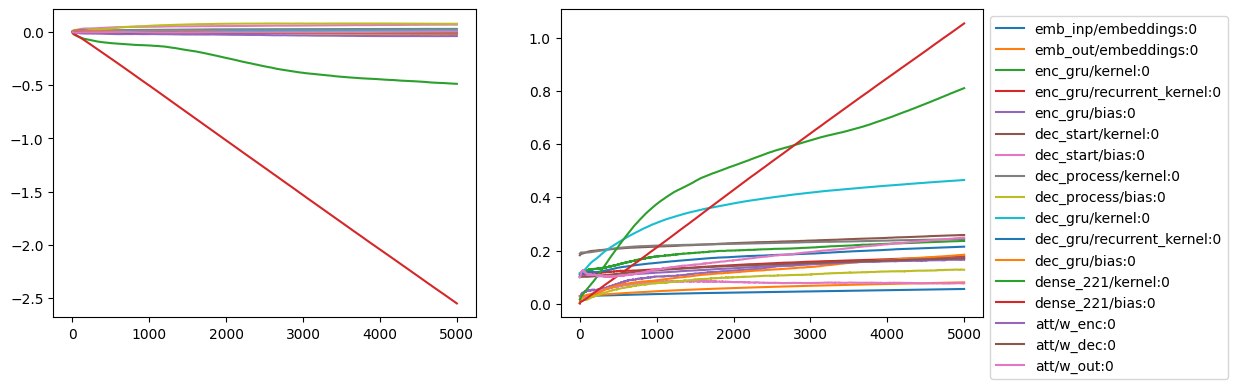

Mean loss=3.581


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [23:23<00:00,  2.14it/s]


In [685]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(3000):
    step = len(metrics2['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(amodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, amodel.trainable_variables)
    opt2.apply_gradients(zip(grads, amodel.trainable_variables))
    
    metrics2['train_loss'].append((step, loss_t.numpy()))

    for v in amodel.variables:
        grad_mean[v.name].append(np.mean(v.numpy()))
        grad_std[v.name].append(np.std(v.numpy()))
    
    if step % 100 == 0:
        metrics2['dev_bleu'].append((step, compute_bleu(amodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics2.items())):
            plt.subplot(1, len(metrics2), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        x = range(1,step+1)
        plt.subplot(1,2,1)
        for key in grad_mean:
            plt.plot(x,grad_mean[key],label = key[19:])
            # plt.legend(loc=2,bbox_to_anchor=(1, 1))

        plt.subplot(1,2,2)
        for key in grad_std:
            plt.plot(x,grad_std[key],label = key[19:])
        plt.legend(loc=2,bbox_to_anchor=(1, 1))     
        plt.show()
            
        
        print("Mean loss=%.3f" % np.mean(metrics2['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

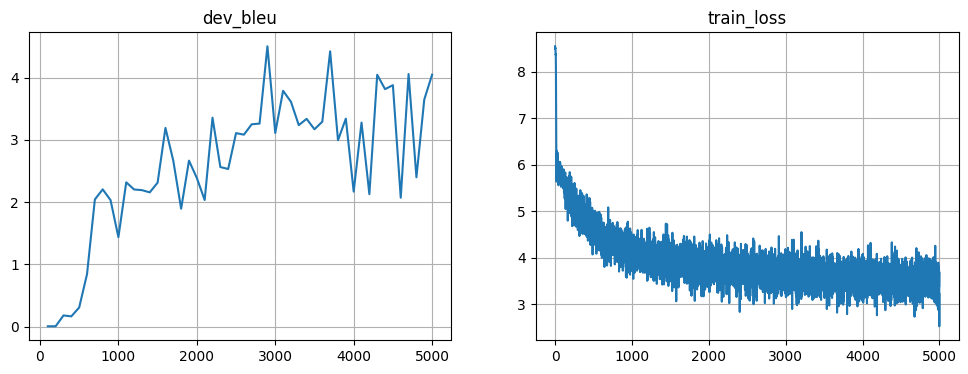

Mean loss=3.441


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:00:00<00:00,  1.39it/s]


In [494]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(5000):
    step = len(metrics2['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(amodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, amodel.trainable_variables)
    opt2.apply_gradients(zip(grads, amodel.trainable_variables))
    
    
    metrics2['train_loss'].append((step, loss_t.numpy()))
    
    if step % 100 == 0:
        metrics2['dev_bleu'].append((step, compute_bleu(amodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics2.items())):
            plt.subplot(1, len(metrics2), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics2['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

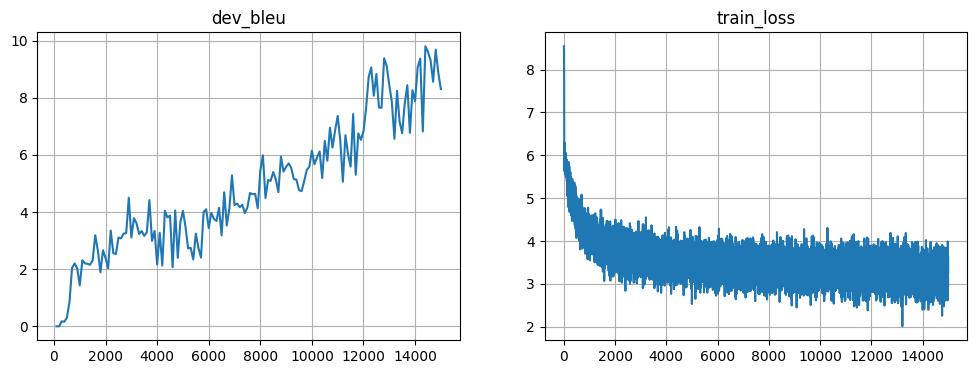

Mean loss=3.315


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:17:15<00:00,  2.16it/s]


In [495]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(10000):
    step = len(metrics2['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(amodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, amodel.trainable_variables)
    opt2.apply_gradients(zip(grads, amodel.trainable_variables))
    
    
    metrics2['train_loss'].append((step, loss_t.numpy()))
    
    if step % 100 == 0:
        metrics2['dev_bleu'].append((step, compute_bleu(amodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics2.items())):
            plt.subplot(1, len(metrics2), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics2['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

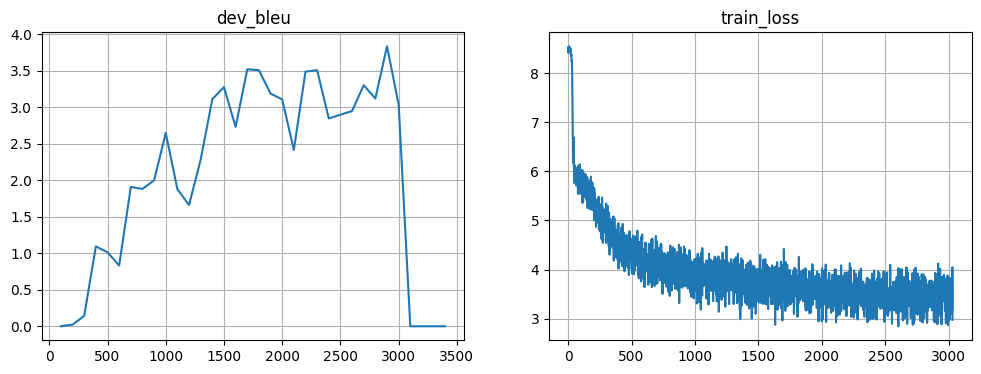

Mean loss=nan


 69%|████████████████████████████████████████████████████████████████▋                             | 3442/5000 [48:16<21:50,  1.19it/s]


KeyboardInterrupt: 

In [463]:
# <YOUR CODE: training loop>

# for _ in trange(25000):
for _ in trange(5000):
    step = len(metrics2['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix])
    batch_out = out_voc.to_matrix(train_out[batch_ix])
    
    with tf.GradientTape() as tape:
         loss_t = compute_loss(amodel, batch_inp, batch_out)
    
    grads = tape.gradient(loss_t, amodel.trainable_variables)
    opt2.apply_gradients(zip(grads, amodel.trainable_variables))
    
    
    metrics2['train_loss'].append((step, loss_t.numpy()))
    
    if step % 100 == 0:
        metrics2['dev_bleu'].append((step, compute_bleu(amodel, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics2.items())):
            plt.subplot(1, len(metrics2), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics2['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
# <YOUR CODE: measure final BLEU>

assert np.mean(metrics2['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

### Legacy code finished

### check model translation result

In [131]:
interval = 600
for inp_line, label_line, att_trans_line, copy_trans_line in zip(dev_inp[::interval], dev_out[::interval], 
                                            attmodel.translate_lines(dev_inp[::interval])[0],
                                            copymodel.translate_lines(dev_inp[::interval])[0]):

    
    print(inp_line)
    print(label_line)
    print(att_trans_line)
    print(copy_trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
a shared equipped kitchen and a common living room are provided to guests .
guests can enjoy a shared kitchen .
the property has a shared kitchen and a shared lounge .

в 5 , 5 км от комплекса работает ближайший супермаркет .
the nearest supermarket is 5 . 5 km from the apartments .
the hotel is 1 . 5 km from the property .
the nearest supermarket is a 5 - minute walk away .

отель st@@ al@@ den расположен на главной доро@@ го , в 4 км до грин@@ дель@@ валь@@ да . гостям предлагаются уютные номера и очаровательный ресторан изысканной швейцар@@ ской кухни .
the stal@@ den hotel is situated on the main road , 4 km before grindelwald and offers you a cosy rooms and a charming restaurant serving fine swiss cuisine .
the hotel is located in the city .
offering a restaurant , hotel is located in the heart of the famous region , 4 km from the famous beaches of the property .

во всех апартаментах отеля h@@ ä@@ us ` l am ru@@ an есть ванная 

### Visualizing model attention (2 point)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.
__Note 2:__ If you're an inclass student, please submit __attention screenshots__ alongside your notebook.

In [88]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

def draw_model_attention(model, input):
    
    if isinstance(model, CopyAttentiveModel):
        trans, states = model.translate_lines(inp)
        attention_probs = []
        for s in states:
            attention_probs.append(s[3])
        attention_probs = tf.stack(attention_probs, axis=1)
        
    else:
        trans, states, probs = model.translate_lines(input)
        attention_probs = probs

    for i in range(5):
        draw_attention(inp[i], trans[i], attention_probs[i].numpy())

inp = dev_inp[5::100]

Loading BokehJS ...

In [89]:
# Attention from copy model
draw_model_attention(copymodel, inp)

In [90]:
# attention model
draw_model_attention(attmodel, inp)

## Going deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot, multi-head)
* use beam search instead of a greedy inference
* word dropout, training schedules, anything you can imagine

We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. Extra work will be rewarded with bonus points :)

As usual, please describe what you tried and what results you obtained in a short report.

`[your report/log here or anywhere you please]`